In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### 一、載入資料

1.1. 載入資料

In [2]:
data = pd.read_csv('/Users/yitsung/Desktop/MasterThesis/data/TaiwanStockData_Top100_EMA')
ticker_2330 = data[data['ticker']==2330].reset_index(drop=True)
ticker_2330 = ticker_2330.drop(columns=['ticker'])
ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.2.轉換成EMA+return data

In [3]:
# origi_data #
origi_data = ticker_2330.copy() # 用來之後還原答案的

# ticker_2330['open'] = ticker_2330['open'].diff()
# ticker_2330['high'] = ticker_2330['high'].diff()
# ticker_2330['low'] = ticker_2330['low'].diff()
# ticker_2330['close'] = ticker_2330['close'].diff()

# # EMA diff #
# ticker_2330['EMA9'] = ticker_2330['EMA9'].diff()
# ticker_2330['EMA12'] = ticker_2330['EMA12'].diff()
# ticker_2330['EMA26'] = ticker_2330['EMA26'].diff()

# ticker_2330.replace([float('inf'), -float('inf')], 0, inplace=True) # 不知道為何有些調整過後會變inf, 要拿掉(應該是連兩天的價格都相同)
# ticker_2330 = ticker_2330.dropna().reset_index(drop=True)

ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.3.切Library和Prediction

In [4]:
Library = ticker_2330[ticker_2330['Date'] < '2023-06-30']
Prediction = ticker_2330[(ticker_2330['Date'] >= '2023-06-30')&(ticker_2330['Date'] <= '2023-10-30')] # 到用11/29預測11/30就好
Prediction.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
680,2023-10-24,543.0,546.0,540.0,544.0,15762.0,156.0,-3681.0,482.0,697.0,-2148.0,3.6302,544.811336,543.613685,541.533870,2.079815,0.428417,93.280883
681,2023-10-25,544.0,551.0,544.0,544.0,17137.0,-99.0,-2573.0,651.0,-142.0,1185.0,3.9095,544.649068,543.673118,541.716547,1.956572,0.734048,91.909547
682,2023-10-26,530.0,535.0,530.0,531.0,31683.0,487.0,-10712.0,-35173.0,-1744.0,-10261.0,6.9033,541.919255,541.723408,540.922728,0.800679,0.747374,85.178131
683,2023-10-27,534.0,536.0,532.0,533.0,17051.0,17.0,-5262.0,1478.0,-73.0,-1739.0,4.1968,540.135404,540.381345,540.335860,0.045485,0.606996,78.927028
684,2023-10-30,531.0,534.0,528.0,532.0,23299.0,265.0,-11811.0,487.0,378.0,-5803.0,5.6532,538.508323,539.091907,539.718389,-0.626481,0.360301,72.836426


### 二、資料分拆

In [5]:
def make_data_minmax(Library, Prediction, target, Tp):

    Library['y'] = Library[f'{target}'].shift(-Tp)
    Library = Library.dropna().reset_index(drop=True)
    Prediction['y'] = Prediction[f'{target}'].shift(-Tp)
    Prediction = Prediction.dropna().reset_index(drop=True)

    ### Minmax ###
    scaler_X = MinMaxScaler()
    feature_to_standardize = Library.columns.to_list()[1 : -1]
    Library[feature_to_standardize] = scaler_X.fit_transform(Library[feature_to_standardize])
    Prediction[feature_to_standardize] = scaler_X.fit_transform(Prediction[feature_to_standardize])

    scaler_y = MinMaxScaler()
    Lib_ans = Library.iloc[:, -1].values.reshape(-1, 1)
    Library.iloc[:, -1] = scaler_y.fit_transform(Lib_ans)
    Pred_ans = Prediction.iloc[:, -1].values.reshape(-1, 1)
    Prediction.iloc[:, -1] = scaler_y.fit_transform(Pred_ans)

    return Library, Prediction, scaler_y

In [6]:
Library, Prediction, scaler_y = make_data_minmax(Library=Library, Prediction=Prediction, target='close', Tp=1)

In [7]:
Prediction.head()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14,y
0,2023-06-30,0.736111,0.779412,0.732394,0.791667,0.467544,0.609867,0.460972,1.000000,0.609983,0.465376,0.565818,0.899545,0.902715,0.769223,1.000000,1.000000,0.361743,0.833333
1,2023-07-03,0.847222,0.838235,0.845070,0.833333,0.109647,0.601575,0.576438,0.471763,0.726554,0.525940,0.093628,0.910096,0.913484,0.793724,0.976195,0.965650,0.351256,0.916667
2,2023-07-04,0.944444,0.911765,0.901408,0.916667,0.160502,0.596186,0.633913,0.457651,0.507363,0.559681,0.114217,0.940569,0.940465,0.827527,0.978584,0.938610,0.322954,0.875000
3,2023-07-05,1.000000,0.970588,0.887324,0.875000,0.117986,0.540630,0.500422,0.469084,0.340102,0.486874,0.106517,0.953932,0.954360,0.853267,0.961077,0.913751,0.186714,0.638889
4,2023-07-06,0.777778,0.750000,0.690141,0.638889,0.433864,0.794776,0.135085,0.468123,0.415905,0.109453,0.429705,0.902198,0.915491,0.845601,0.865351,0.876223,0.081164,0.638889


In [8]:
X_train, y_train = Library.iloc[:,1:-1], Library.iloc[:,-1]
X_test, y_test = Library.iloc[:,1:-1], Library.iloc[:,-1]

### 三、建模分析

3.1. 建構XGBR model

In [9]:
# parameters = {'n_estimators':range(10, 300, 10),
#               'max_depth':range(2,10,1),
#               'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
#               'min_child_weight':range(5, 21, 1),
#               'subsample':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#               'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1]
#              }

# model = XGBRegressor(seed=87, # model_seed
#                      n_estimators=100,
#                      max_depth=3,
#                      eval_metric='rmse',
#                      learning_rate=0.1,
#                      min_child_weight=1,
#                      subsample=1,
#                      colsample_bytree=1,
#                      colsample_bylevel=1,
#                      gamma=0)

In [10]:
def train_XGBR_model(parameters, X, y):

    val_fold = [-1] * int(len(X)*0.8) + [0] * int(len(X)*0.2) # 後20%用來validation
    ps = PredefinedSplit(test_fold=val_fold)

    model = XGBRegressor()
    XGBR_model = GridSearchCV(estimator=model, param_grid=parameters, cv=ps, 
                              refit=True, scoring='neg_mean_squared_error')

    XGBR_model.fit(X,y)
    print('最佳參數: ', XGBR_model.best_params_)

    return XGBR_model

parameters = {'n_estimators':range(100, 1000, 100),
              'max_depth':range(2,10,2),
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5]}

XGBR_model = train_XGBR_model(parameters=parameters, X=X_train, y=y_train)
# 最佳參數:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}

最佳參數:  {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300}


3.2. 進行預測並檢視結果

In [11]:
def predict_valuation(XGBR_model, X_pred, scaler_y, origi_data):

    ### 預測 ###
    y_pred = XGBR_model.predict(X_pred)
    y_pred = y_pred.reshape(-1,1) # reshape成可以還原的格式
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.Series(y_pred.reshape(-1)) # 變成series格式化成相同index方便畫圖

    # 取得前一日資料
    yesterday = origi_data[(origi_data['Date']>='2023-06-30') & (origi_data['Date']<'2023-10-31')].reset_index(drop=True)
    # 取得今日資料
    Today = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-11-01')].reset_index(drop=True)
    # Date
    Date = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-11-01')].reset_index()

    # 製作還原預測資料
    XGBR_result = pd.DataFrame(yesterday['close'])
    XGBR_result = XGBR_result.rename(columns={'close': 'Yesterday'})

    XGBR_result['Predictions'] = y_pred # origin
    # XGBR_result['Predictions'] = XGBR_result['Yesterday'] + y_pred # diff

    XGBR_result['Observations'] = Today['close']   
    XGBR_result['Date'] = Date['Date']

    XGBR = XGBR_result[['Date', 'Observations', 'Predictions', 'Yesterday']]

    # 繪圖
    plt.figure(figsize=(16, 9))
    plt.plot(XGBR['Date'], XGBR[f'Observations'], linewidth=3, label='true')
    plt.plot(XGBR['Date'], XGBR[f'Predictions'], linewidth=3, label='pred')
    plt.plot(XGBR['Date'], XGBR[f'Yesterday'], linestyle='--', label='yesterday')

    plt.xlabel('Date')
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Price')
    plt.title(f'2330 EMA XGBR: close')
    plt.legend()
    plt.show()

    return XGBR

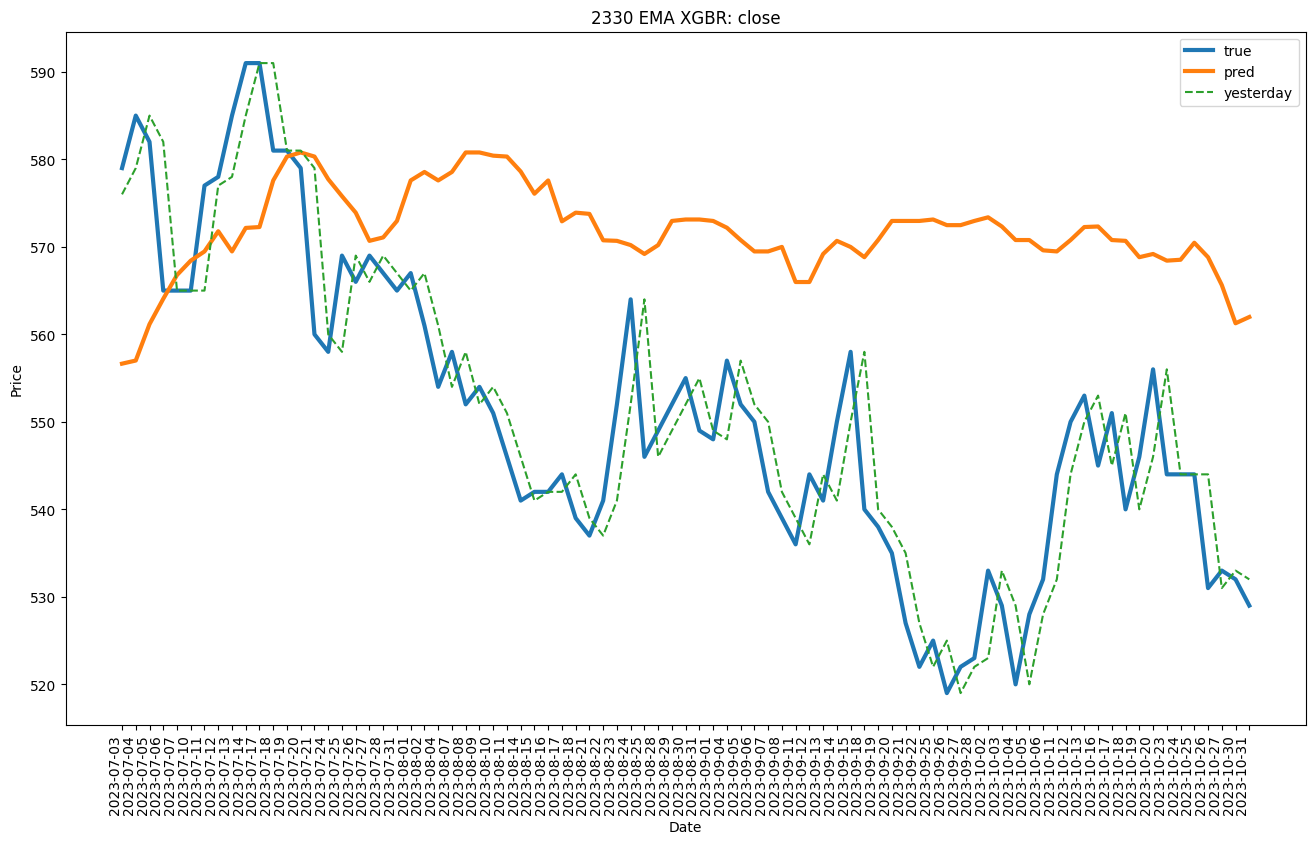

,Date,Observations,Predictions,Yesterday
0,2023-07-03,579.0,556.648010,576.0
1,2023-07-04,585.0,557.007568,579.0
2,2023-07-05,582.0,561.160461,585.0
3,2023-07-06,565.0,564.061035,582.0
4,2023-07-07,565.0,566.780212,565.0
5,2023-07-10,565.0,568.422363,565.0
6,2023-07-11,577.0,569.476746,565.0
7,2023-07-12,578.0,571.782837,577.0
8,2023-07-13,585.0,569.476746,578.0
9,2023-07-14,591.0,572.164246,585.0


In [12]:
XGBR = predict_valuation(XGBR_model=XGBR_model, 
                         X_pred=X_test,
                         scaler_y=scaler_y,
                         origi_data=origi_data)
XGBR.head(60)